## In this notebook, you will learn principally how to use
 
- ImageDataGenerator,
- Differents Pretrained Models


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./DetectSurface/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./DetectSurface/bongtroc\1-6.jpg
./DetectSurface/bongtroc\cach loai bo bong bong tren tuong.jpg
./DetectSurface/bongtroc\download (1).jpg
./DetectSurface/bongtroc\download (2).jpg
./DetectSurface/bongtroc\download (3).jpg
./DetectSurface/bongtroc\download (4).jpg
./DetectSurface/bongtroc\download (5).jpg
./DetectSurface/bongtroc\download.jpg
./DetectSurface/bongtroc\downloadk.jpg
./DetectSurface/bongtroc\images (1).jpg
./DetectSurface/bongtroc\images (2).jfif
./DetectSurface/bongtroc\images (2)k.jfif
./DetectSurface/bongtroc\images (3).jfif
./DetectSurface/bongtroc\images (4).jfif
./DetectSurface/bongtroc\images (5).jfif
./DetectSurface/bongtroc\images (6).jfif
./DetectSurface/bongtroc\images.jpg
./DetectSurface/bongtroc\sơn tường bị bong tróc ảnh hưởng đến thẩm mỹ và hỏng tường.jpg
./DetectSurface/bongtroc\tinh-trang-tuong-bi-bong-troc-do-tham-nuoc-lau-ngay.jpg
./DetectSurface/bongtroc\tinh-trang-tuong-bi-bong-troc-do-tham-nuoc-lau-ngayk.jpg
./DetectSurface/bongtroc\tuong-bong-troc-2.

# Libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

# Preparing the Dataset

In [3]:
# Let's create a function to see some images 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

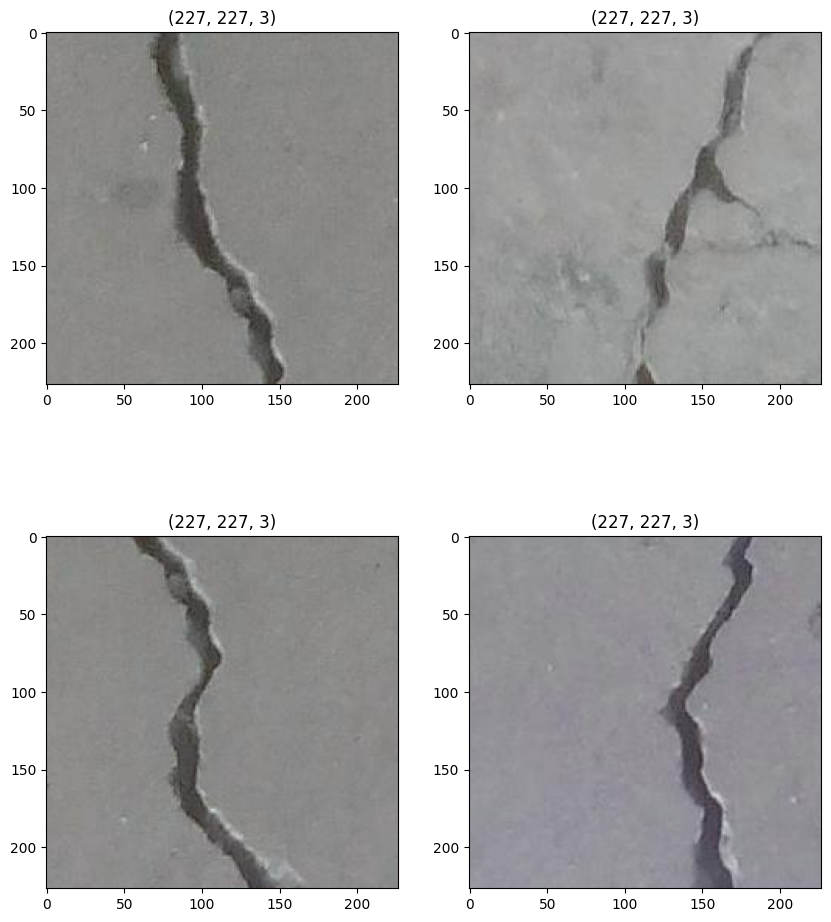

In [5]:
load_images_from_folder("./DetectSurface/Positive_500samples")

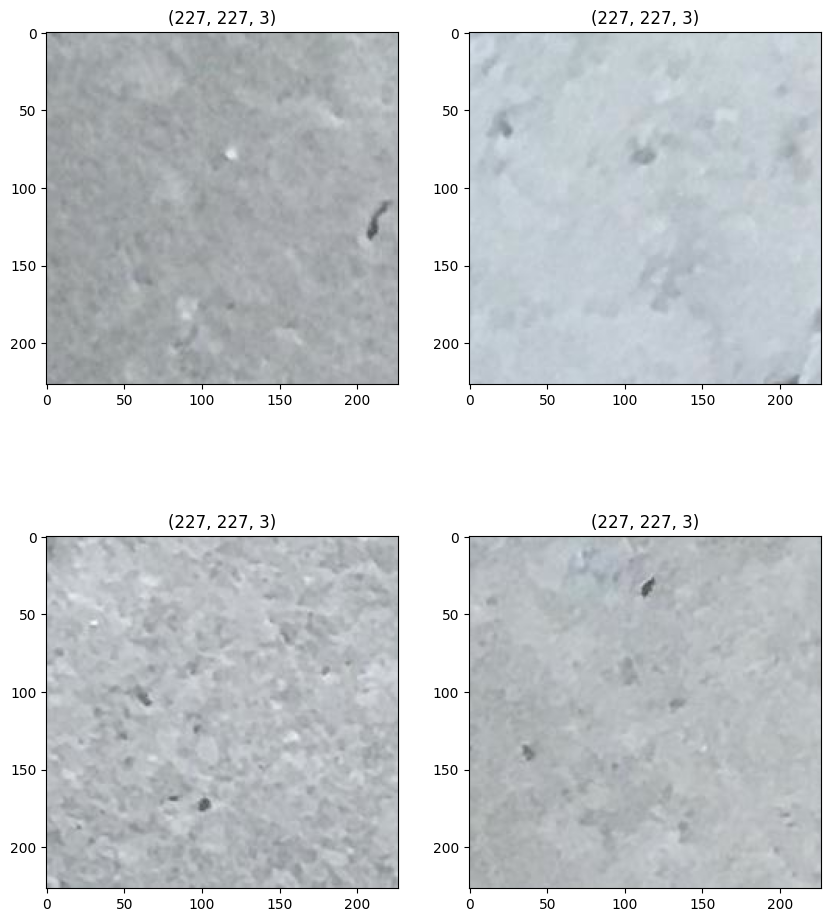

In [6]:
load_images_from_folder("./DetectSurface/Negative_500samples")

In [3]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

## 1. Inception V3 

https://www.kaggle.com/keras/inceptionv3

Inception-v3 is a convolutional neural network that is 48 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299.

In [6]:
# You have to add Inception V3 files from 
# file--> add or upload data-->search by URL--> https://www.kaggle.com/keras/inceptionv3
!ls /kaggle/input


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
     layer.trainable = False
        
# Print the model summary
# pre_trained_model.summary()

In [5]:
# We will use the part of the pre_trained model from input later until the layer 'mixed7'
# You can also choose different layer for starting
last_layer = pre_trained_model.get_layer('mixed7') 
last_output = last_layer.output
#Then we add our layers 

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)            

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
# Create Data Generator
# Split data train-validation sets by using validation_split=0.3
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory('./data',
                                                     target_size=(150,150),
                                                     batch_size=6,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training')            


Found 853 images belonging to 3 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

validation_generator =  validation_datagen.flow_from_directory('./data',
                                                                target_size=(150,150),
                                                                batch_size=6,
                                                                class_mode='categorical',
                                                                subset='validation')          
                                       

Found 365 images belonging to 3 classes.


In [8]:
callbacks = myCallback()

history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            epochs = 20,
            verbose = 1,
            )

C:\Users\Admin\AppData\Local\Temp\ipykernel_7684\968473103.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
143/143 [==============================] - 139s 933ms/step - loss: 6.5640 - accuracy: 0.8265 - val_loss: 2.1035 - val_accuracy: 0.8082
Epoch 2/20
143/143 [==============================] - 111s 777ms/step - loss: 0.9043 - accuracy: 0.9461 - val_loss: 0.5976 - val_accuracy: 0.8849
Epoch 3/20
143/143 [==============================] - 114s 797ms/step - loss: 0.7152 - accuracy: 0.9379 - val_loss: 1.7549 - val_accuracy: 0.8521
Epoch 4/20
143/143 [==============================] - 115s 801ms/step - loss: 0.2136 - accuracy: 0.9730 - val_loss: 0.3467 - val_accuracy: 0.9534
Epoch 5/20
143/143 [==============================] - 110s 770ms/step - loss: 0.1207 - accuracy: 0.9894 - val_loss: 0.3941 - val_accuracy: 0.9726
Epoch 6/20
143/143 [==============================] - 113s 789ms/step - loss: 0.1246 - accuracy: 0.9848 - val_loss: 0.4595 - val_accuracy: 0.9425
Epoch 7/20
143/143 [==============================] - 107s 748ms/step - loss: 0.1610 - accuracy: 0.9930 - val_loss: 1.0193 -

In [ ]:
import pickle
pickle.dump(model,open('./Models/modelIncept_batchsize=10_epo=8.pkl','wb'))

# model= pickle.load(open('model.pkl', 'rb'))
# print(model.predict(...))

In [71]:
modelTest= pickle.load(open('./Models/modelIncept.pkl', 'rb'))

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://73e992b6-1563-4b9c-861f-c51569d915d5/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

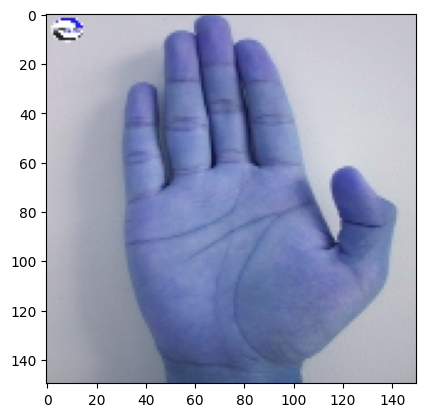

In [60]:
import matplotlib.pyplot as plt
img_arr=cv2.imread('./DetectSurface/test1/3.jpg')

img = cv2.resize(img_arr, (150, 150)) 
img=img/255
plt.imshow(img)
# img.reshape(1,150,150,3)

# cv2.imshow('image', img)


In [63]:
np.array([img]).shape

(1, 150, 150, 3)

In [65]:
result=model.predict(np.array([img]))
print(result)

1/1 [==============================] - 3s 3s/step
[[0.99964935]]


[[0.99976414]]


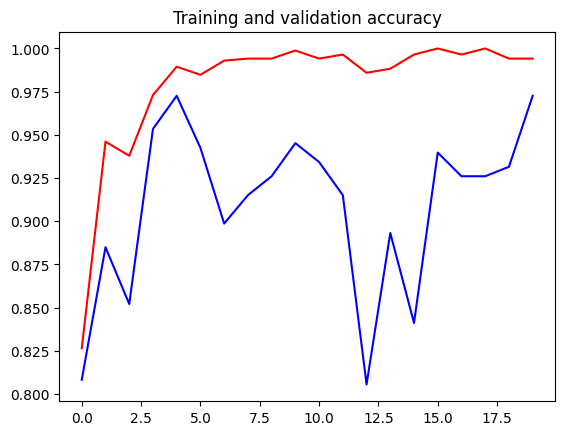

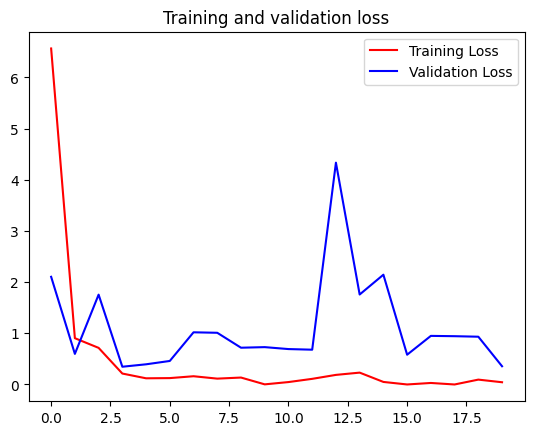

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

### How to Save a Model
- Since training can take a long time when building deep learning models, it is always a good idea to save your model once the training is complete if you believe you will be using the model again later.

In [21]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
model.save('./Models/InceptionV3_batchsize=20_final.h5')

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("./Models/Inception_batchsize=10_epo=8.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

model.save_weights("WeightIncept_batchsize=10_epo=8.h5")
print("Saved model to disk")
 
# # later...
 
# # load json and create model
# from tensorflow.keras.models import Sequential, model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


<hr>

TEST MODEL

In [8]:
import numpy as np
from PIL import Image
from keras.models import load_model

In [21]:
#Load the trained model. (Pickle file)
my_model = load_model('./Models/InceptionV3_batchsize=10_epo=8.h5')

In [24]:
def getPrediction(filename):
    
    # classes = ['Have No Crack', 'Have Crack']
    # le = LabelEncoder()
    # le.fit(classes)
    # le.inverse_transform([])

    SIZE = 150 #Resize to same size as training images
    img_path = filename
    img = np.asarray(Image.open(img_path).resize((SIZE,SIZE)))
    
    img = img/255.      #Scale pixel values
    
    img = np.expand_dims(img, axis=0)  #Get it tready as input to the network       
    
    pred = my_model.predict(img) #Predict    
    # print(pred)                

    #Convert prediction to class name
    # pred_class = le.inverse_transform([predClass])[0]
    # print("Diagnosis of crack detection is:", pred)
    return pred

In [30]:
test_prediction = getPrediction('DetectSurface/Test bị sai/22.jpg')
test_prediction

1/1 [==============================] - 0s 109ms/step


array([[1.]], dtype=float32)

### How to Load a Model

In [16]:
!ls /kaggle/working

Crack_Detection_InceptionV3_model.h5  __notebook__.ipynb


In [72]:
# load model
from keras.models import load_model

model_inception = load_model('./Models/Crack_Detection_InceptionV3_final.h5')
# summarize model.
#model_inception.summary()

In [74]:
result=model_inception.predict(np.array([img]))
print(result)

1/1 [==============================] - 3s 3s/step
[[0.99964935]]


## 2. VGG16

https://www.kaggle.com/keras/vgg16

The input to conv1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time.

In [11]:
from tensorflow.keras.applications import VGG16

weights_file='./Models/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights =None)

pretrained_model.load_weights(weights_file)

for layer in pretrained_model.layers:
     layer.trainable = False

pretrained_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(3, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory('./data',
                                                     target_size=(150,150),
                                                     batch_size=6,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training') 

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

validation_generator =  validation_datagen.flow_from_directory('./data',
                                                                target_size=(150,150),
                                                                batch_size=6,
                                                                class_mode='categorical',
                                                                subset='validation')  

Found 853 images belonging to 3 classes.
Found 365 images belonging to 3 classes.


In [14]:
callbacks = myCallback()

history = model_vgg.fit_generator(train_generator,
                                  validation_data = validation_generator,
                                  epochs = 20,
                                  verbose = 1)
                                 #  ,callbacks=[callbacks])


C:\Users\Admin\AppData\Local\Temp\ipykernel_7684\1025518272.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_vgg.fit_generator(train_generator,


Epoch 1/20
143/143 [==============================] - 231s 2s/step - loss: 1.2432 - accuracy: 0.7655 - val_loss: 0.2438 - val_accuracy: 0.9151
Epoch 2/20
143/143 [==============================] - 223s 2s/step - loss: 0.3242 - accuracy: 0.8781 - val_loss: 0.0836 - val_accuracy: 0.9781
Epoch 3/20
143/143 [==============================] - 251s 2s/step - loss: 0.2036 - accuracy: 0.9297 - val_loss: 0.1740 - val_accuracy: 0.9534
Epoch 4/20
143/143 [==============================] - 262s 2s/step - loss: 0.1799 - accuracy: 0.9414 - val_loss: 0.2048 - val_accuracy: 0.9315
Epoch 5/20
143/143 [==============================] - 299s 2s/step - loss: 0.1489 - accuracy: 0.9508 - val_loss: 0.1409 - val_accuracy: 0.9479
Epoch 6/20
143/143 [==============================] - 252s 2s/step - loss: 0.1670 - accuracy: 0.9637 - val_loss: 0.0837 - val_accuracy: 0.9699
Epoch 7/20
143/143 [==============================] - 219s 2s/step - loss: 0.1023 - accuracy: 0.9730 - val_loss: 0.0792 - val_accuracy: 0.9808

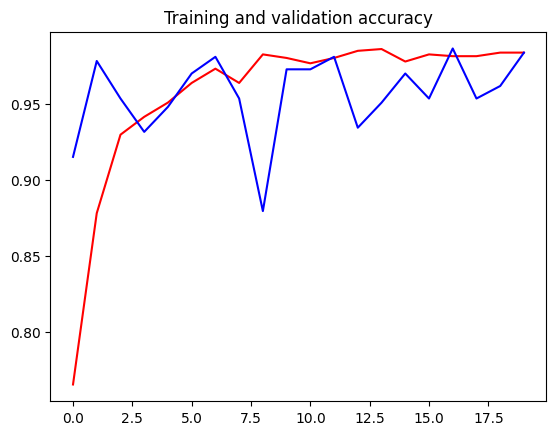

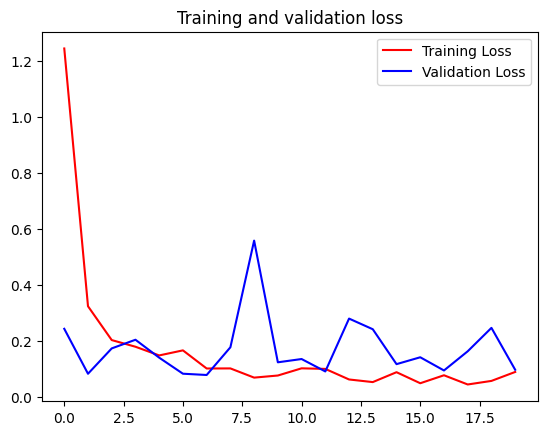

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [16]:
model_vgg.save('./Models/VGG16/VGG16_batchsize=6_epo=20_final2.h5')

test VGG


In [3]:
#Load the trained model. (Pickle file)
model_vgg = load_model('./Models/VGG16/VGG16_batchsize=32_epo=10.h5')

def getPrediction(filename,my_model):
    
    # classes = ['Have No Crack', 'Have Crack']
    # le = LabelEncoder()
    # le.fit(classes)
    # le.inverse_transform([])

    SIZE = 150 #Resize to same size as training images
    img_path = filename
    img = np.asarray(Image.open(img_path).resize((SIZE,SIZE)))
    
    img = img/255.      #Scale pixel values
    
    img = np.expand_dims(img, axis=0)  #Get it tready as input to the network       
    
    pred = my_model.predict(img) #Predict    
    # print(pred)                

    #Convert prediction to class name
    # pred_class = le.inverse_transform([predClass])[0]
    # print("Diagnosis of crack detection is:", pred)
    return pred


# test_prediction =getPrediction('8.jpg')

In [4]:
test_prediction =getPrediction('DetectSurface/Test bị sai/20.jpg',model_vgg)
test_prediction

1/1 [==============================] - 2s 2s/step


array([[0.00047652]], dtype=float32)

In [24]:
!ls /kaggle/working

Crack_Detection_InceptionV3_model.h5  __notebook__.ipynb
Crack_Detection_VGG16_model.h5


## ResNet50 

https://www.kaggle.com/keras/resnet50

ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients. AlexNet, the winner of ImageNet 2012 and the model that apparently kick started the focus on deep learning had only 8 convolutional layers, the VGG network had 19 and Inception or GoogleNet had 22 layers and ResNet 152 had 152 layers. In this blog we will code a ResNet-50 that is a smaller version of ResNet 152 and frequently used as a starting point for transfer learning.

In [25]:
# You have to add ResNet50 files from 
# file--> add or upload data-->search by URL--> https://www.kaggle.com/keras/resnet50


In [8]:
# from tensorflow.keras.applications import ResNet50
# import tensorflow.keras.applications.ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense

In [18]:
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   preprocessing_function=preprocess_input) # don't use rescale = 1./255

train_generator = train_datagen.flow_from_directory('./data',
                                                     target_size=(224,224),
                                                     batch_size=6,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training')

validation_datagen = ImageDataGenerator(validation_split=0.3,
                                        preprocessing_function=preprocess_input)

validation_generator =  validation_datagen.flow_from_directory('./data',
                                                                target_size=(224,224),
                                                                batch_size=6,
                                                                class_mode='categorical',
                                                                subset='validation')     

Found 853 images belonging to 3 classes.
Found 365 images belonging to 3 classes.


In [20]:
model_res50 = Sequential()

model_res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

model_res50.add(Dense(3, activation='softmax'))

model_res50.layers[0].trainable = False 

model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
callbacks = myCallback()

model_res50.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


fit_history = model_res50.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    validation_steps=steps_per_epoch_validation,
    epochs=20,
    validation_data=validation_generator,
    verbose=1
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10716\3694675894.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model_res50.fit_generator(


Epoch 1/20
143/143 [==============================] - 248s 2s/step - loss: 0.1785 - accuracy: 0.9508 - val_loss: 0.2108 - val_accuracy: 0.9096
Epoch 2/20
143/143 [==============================] - 195s 1s/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.0453 - val_accuracy: 0.9836
Epoch 3/20
143/143 [==============================] - 194s 1s/step - loss: 0.0112 - accuracy: 0.9988 - val_loss: 0.0427 - val_accuracy: 0.9890
Epoch 4/20
143/143 [==============================] - 169s 1s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.9890
Epoch 5/20
143/143 [==============================] - 173s 1s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9918
Epoch 6/20
143/143 [==============================] - 178s 1s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9890
Epoch 7/20
143/143 [==============================] - 173s 1s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.9890

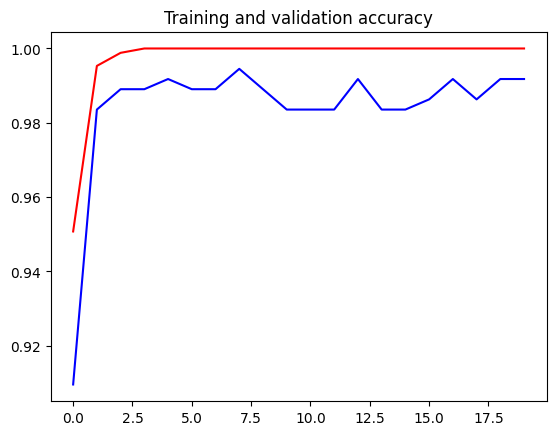

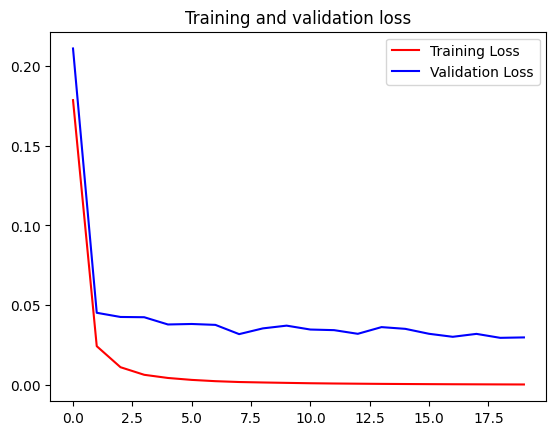

In [22]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [23]:
model_res50.save('./Models/RESNET/ResNet50_batchsize=6_ver2.h5')

In [32]:
!ls /kaggle/working

Crack_Detection_InceptionV3_model.h5  Crack_Detection_VGG16_model.h5
Crack_Detection_ResNet50_model.h5     __notebook__.ipynb


## Conclusion

- Apparently ResNet50 has the best result for this dataset.
- But we can also get similar results with others by changing some hyperparameters 

<hr>
Test Pretrained Resnet50